### Library Imports

This code cell imports essential libraries used throughout the notebook:

- **Standard libraries**: `os`, `glob`, `random` for file and system operations.
- **Image processing**: `cv2` (OpenCV) and `matplotlib` for image I/O and visualization.
- **Numerical operations**: `numpy`, `pandas` for data handling.
- **Progress tracking**: `tqdm` for visual progress bars.
- **Machine learning**: 
  - `sklearn` for data splitting, label encoding, and metrics.
  - `torch`, `torchvision`, and `timm` for deep learning models and utilities.
- **AMP (Automatic Mixed Precision)**: `autocast`, `GradScaler` for optimizing training performance and memory usage.

In [4]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
import pandas as pd
import random
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as skm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

### Configuration Class with Auxiliary Loss Weight

Defines a centralized `CFG` class that holds all hyperparameters and settings for the training pipeline. This makes the codebase easier to maintain and adjust.

---

**1. Model and Training Settings**  
- `model_name`: Specifies the backbone architecture from the `timm` library (e.g., EfficientNet B4 pretrained on JFT).  
- `img_size`: Target resolution for all input images.  
- `batch_size`, `learning_rate`, `epochs`: Core training parameters.

---

**2. Cross-Validation Settings**  
- `folds`: Total number of K-Folds used for cross-validation.  
- `selected_folds`: Specifies which folds to train on (optional if want to train on fewer data).  
- `seed`: Ensures reproducible data splits and model behavior.

---

**3. Loss Function Selection**  
- `loss`: Can be set to use Focal Loss instead of Binary Cross-Entropy, which is helpful for class imbalance.

---

**4. Data Augmentation Settings**  
- `augment`: Toggles data augmentation.  
- Includes both geometric (`hflip`, `vflip`, `rot`) and pixel-level augmentations (`bri`, `cont`, `sat`, `hue`), with probabilities controlled by `pixel_aug`.

These augmentations increase input diversity and improve the model's generalization to different visual variations.

---

**5. Auxiliary Learning**  
- `aux_loss_weight`: Controls how much the auxiliary targets influence training.  
  For example, a value of `0.4` means the auxiliary classification heads contribute 40% to the total loss, and the main cancer loss contributes 60%.

This lets the model benefit from learning additional related features (like view, site, age) without letting those targets dominate the learning process.

---

This configuration structure improves readability and enables flexible experimentation across model runs.

In [2]:
# CONFIGURATION
class CFG:
    model_name = 'tf_efficientnet_b4.ns_jft_in1k'
    img_size = (512, 512)
    batch_size = 16
    
    epochs = 8
    folds = 4
    
    seed = 42
    selected_folds = [0, 1, 2, 3]
    learning_rate = 1e-4
    loss = 'focal'
    augment = True
    hflip = True
    vflip = True
    rot = 2.0
    cont = [0.8, 1.2]
    bri = 0.15
    sat = [0.7, 1.3]
    hue = 0.05
    pixel_aug = 0.90
    aux_loss_weight = 0.4  # (0.4 weight for aux targets (40%): ADJUSTABLE)


### Set Random Seed for Reproducibility

Defines and calls a `set_seed` function to fix randomness across libraries:

- Seeds the Python `random`, `numpy`, and `torch` libraries.
- Ensures deterministic behavior on GPU by configuring cuDNN backend.
- Uses `CFG.seed` as the base seed for consistency.

This ensures that results are reproducible across training runs and hardware setups.

In [3]:
# SEEDING
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CFG.seed)

### Load and Prepare Training Data with Encoded Auxiliary Targets

This step loads the dataset, constructs file paths for each image, and prepares the auxiliary targets for multi-task learning.

---

**1. Load CSV and Clean Image ID**  
- Reads the dataset from `trimmed_train.csv` into `train_df`.
- Converts `image_id` to a clean string using `.astype(str).str.strip()` to avoid path errors.

---

**2. Construct Image Paths**  
- Defines a helper function `get_image_path(...)` to build the file path to each ROI image using the `patient_id` and `image_id`.
- Adds a new column `image_path` to the dataframe using `apply(...)` so each row has a direct link to its image.

---

**3. Process Auxiliary Targets**  
- Fills missing `age` values with the column mean using `.fillna(...)`.
- Converts `age` into 10 equally sized bins using `pd.qcut(..., labels=False)`, turning it into a categorical feature with values from 0 to 9.
- Defines a list `AUX_TARGETS` containing all the auxiliary variables to be learned by the model alongside the cancer label.
- Applies label encoding to all categorical targets using `LabelEncoder().fit_transform(...)` to convert them to integer classes.
- Calculates `AUX_TARGET_NCLASSES` which stores the number of unique classes per target, needed when building classification heads for each auxiliary target.

---

**4. Print Class Summary**  
- Iterates through each auxiliary target to print its unique values and class counts for verification.

In [4]:
# LOAD TRAIN.CSV
train_df = pd.read_csv("input/trimmed_train.csv")

# CLEAN DATA
train_df['image_id'] = train_df['image_id'].astype(str).str.strip()

def get_image_path(patient_id, image_id):
    return f"input/roi/trimmed_train_images_roi/{patient_id}/{image_id}.png"

train_df['image_path'] = train_df.apply(lambda row: get_image_path(row['patient_id'], row['image_id']), axis=1)


# ENCODE AUX TARGETS
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['age'] = pd.qcut(train_df['age'], 10, labels=False).astype(int)
AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 
               'invasive', 'BIRADS', 'density', 'difficult_negative_case', 
               'machine_id', 'age']

CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id']
train_df[CATEGORY_AUX_TARGETS] = train_df[CATEGORY_AUX_TARGETS].apply(LabelEncoder().fit_transform)
AUX_TARGET_NCLASSES = train_df[CATEGORY_AUX_TARGETS].max() + 1

for col in AUX_TARGETS:
    uniques = sorted(train_df[col].unique())
    n_classes = train_df[col].nunique()

    print(f"--- {col} ---")
    print(f"Unique labels in data: {uniques}")
    print(f"Number of classes expected: {n_classes}")
    print()

--- site_id ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- laterality ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- view ---
Unique labels in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Number of classes expected: 4

--- implant ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- biopsy ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- invasive ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- BIRADS ---
Unique labels in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Number of classes expected: 4

--- density ---
Unique labels in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Number of classes expected: 5

--- difficult_negative_case ---
Unique labels in data: [np.int64(0), np.int64(1)]
Number of classes expected: 2

--- machine_id ---
Un

### Stratified Train-Test Split and Fold Assignment

Split the dataset into train and test sets and prepares fold labels for cross-validation.

---

**1. Split Dataset**  
- Uses `train_test_split` to divide `train_df` into 80% training and 20% testing data.
- Stratifies based on the `cancer` label so that both subsets reflect the original class distribution.
- Sets a fixed random seed (`CFG.seed`) to ensure reproducibility of the split.

Using stratification keeps the cancer label balanced in both sets, and the test set is saved for final evaluation.

---

**2. Reset Indexes**  
- Resets the indices of both training and test DataFrames with `.reset_index(drop=True)`.

This ensures that the row indices are clean and consistent after the split, which avoids indexing issues during training and fold assignment.

---

**3. Stratified K-Fold Assignment**  
- Initializes `StratifiedGroupKFold` to assign fold numbers within the training set.
- Stratifies on `cancer` to maintain class balance across all folds.
- Groups by `patient_id` to ensure that all images from the same patient stay within the same fold, avoiding data leakage.

K-Fold is used here to maximize data efficiency, allowing the model to be trained and validated on multiple subsets of the data.  
Each sample gets a chance to be part of a validation set, and performance averaged across folds gives a more stable estimate of generalization.

In [5]:
# TRAIN-TEST SPLIT
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df['cancer'],
    random_state=CFG.seed
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# STRATIFIED K-FOLD
skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
train_df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df['cancer'], groups=train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

### Compute Probabilistic Evaluation Metrics

Defines `compute_metrics` to evaluate model performance using multiple metrics based on predicted probabilities.

---

**Inputs**  
- `y_pred`: Model’s predicted probabilities.  
- `y_true`: Ground-truth binary labels.  
- `beta`: Emphasis factor for recall in F-beta calculation (default is 2.0).

---

**1. Probabilistic F-beta Score (pF1)**  
- Computes a soft F-beta score directly from the raw predicted probabilities (no thresholding).
- Balances precision and recall but emphasizes **recall** more due to `beta=2.0`.  
- This beta value is because **missing a positive case (false negative)** is more crucial than a false positive.

**This is the main metric used for model selection** because it evaluates performance directly from predicted probabilities, without committing to a fixed threshold. Unlike thresholded metrics, it acts as a stricter measure by penalizing uncertain or hesitant predictions, which is more appropriate for the serious nature of medical diagnosis where confident and correct probabilities are critical.

---

**2. Thresholded F1 Score**  
- Searches for the optimal classification threshold between 0.0 and 1.0.
- Applies hard thresholding at each step and computes the F1 score.
- Returns the best F1 score and corresponding threshold.

---

**3. AUC (Area Under the ROC Curve)**  
- Measures the model's ability to rank positive samples above negative ones.
- Threshold-independent metric useful for understanding overall ranking performance.

---

**Returns**  
- `pf_beta`: Probabilistic F-beta score  
- `best_thr_f1`: Best F1 score after thresholding  
- `auc`: ROC-AUC score  
- `best_thr`: Threshold at which best F1 was achieved

In [6]:
def compute_metrics(y_pred, y_true, beta=2.0):
    y_pred = np.clip(y_pred, 0, 1)
    y_true = np.array(y_true)
    eps = 1e-7
    beta_squared = beta ** 2

    # --- Probabilistic F-beta
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()

    pf_beta = (1 + beta_squared) * tp / ((1 + beta_squared) * tp + beta_squared * fn + fp + eps)

    # --- Thresholded F1
    best_thr_f1 = 0.0
    best_thr = None
    for thr in np.linspace(0.0, 1.0, 50):
        bin_pred = (y_pred > thr).astype(np.float32)
        score = skm.f1_score(y_true, bin_pred)
        if score > best_thr_f1:
            best_thr_f1 = score
            best_thr = thr

    # --- AUC
    auc = skm.roc_auc_score(y_true, y_pred)

    return pf_beta, best_thr_f1, auc, best_thr

### Compute Thresholded Classification Metrics

Defines `compute_classification_metrics` to evaluate predictions by applying a fixed probability threshold.

---

**Inputs**  
- `y_pred`: Model's predicted probabilities.  
- `y_true`: Ground-truth binary labels.  
- `threshold`: Value between 0 and 1 used to convert probabilities into binary predictions (1 if above threshold, else 0).

---

**How it works**  
- Converts probabilities to binary labels using the specified threshold:  
  `y_pred_bin = (y_pred > threshold)`
- Calculates four standard classification metrics:
  - **Accuracy**: Overall proportion of correct predictions.
  - **Precision**: Among predicted positives, how many were actually positive.
  - **Recall**: Among actual positives, how many were correctly predicted.
  - **F1 Score**: Harmonic mean of precision and recall, useful when dealing with imbalanced classes.

`zero_division=0` avoids errors when there are no predicted positives or no true positives.

---

**Returns**  
- A dictionary with all four metrics: `acc`, `prec`, `rec`, and `f1`.

In [7]:
def compute_classification_metrics(y_pred, y_true, threshold):
    
    y_pred_bin = (np.array(y_pred) > threshold).astype(np.float32)
    y_true = np.array(y_true)

    return {
        'acc': skm.accuracy_score(y_true, y_pred_bin),
        'prec': skm.precision_score(y_true, y_pred_bin, zero_division=0),
        'rec': skm.recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': skm.f1_score(y_true, y_pred_bin)
    }

### Distribution of Cancer Labels Across Dataset Splits and Folds

This block prints summaries to verify the balance of cancer labels (`0` and `1`) across various dataset partitions:

- **Overall Distribution**:
  - Shows the count and proportion of each label (`cancer=0` and `cancer=1`) in the full training set.

- **Train vs. Test Split**:
  - Displays absolute and relative distribution of cancer labels in both the training and test sets, confirming stratified splitting.

- **Per-Fold Distribution**:
  - For each fold (from 0 to `CFG.folds - 1`), prints:
    - Total number of samples
    - Count of positive (`cancer=1`) and negative (`cancer=0`) labels
    - Proportion of positive cases

In [8]:
# SUMMARY OF CANCER DIST
print("\nOverall Cancer Label Distribution:")
print(train_df['cancer'].value_counts())
print(train_df['cancer'].value_counts(normalize=True).rename("proportion"))

print("\nTrain/Validation/Test split distribution:")
for subset_name, subset_df in zip(['Train', 'Test'], [train_df, test_df]):
    print(f"{subset_name} Set:")
    print(subset_df['cancer'].value_counts())
    print(subset_df['cancer'].value_counts(normalize=True).rename("proportion"))
    print()

# SUMMARY PER FOLD
print("\nDistribution per Fold in Train:")
for fold in range(CFG.folds):
    fold_data = train_df[train_df['fold'] == fold]
    counts = fold_data['cancer'].value_counts().to_dict()
    total = len(fold_data)
    print(f"Fold {fold}:")
    print(f"  Total: {total}")
    print(f"  Cancer=1: {counts.get(1, 0)} | Cancer=0: {counts.get(0, 0)}")
    print(f"  Ratio: {(counts.get(1, 0) / total):.4f} cancer\n")


Overall Cancer Label Distribution:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Train/Validation/Test split distribution:
Train Set:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Test Set:
cancer
0    1158
1     232
Name: count, dtype: int64
cancer
0    0.833094
1    0.166906
Name: proportion, dtype: float64


Distribution per Fold in Train:
Fold 0:
  Total: 1392
  Cancer=1: 233 | Cancer=0: 1159
  Ratio: 0.1674 cancer

Fold 1:
  Total: 1420
  Cancer=1: 238 | Cancer=0: 1182
  Ratio: 0.1676 cancer

Fold 2:
  Total: 1322
  Cancer=1: 237 | Cancer=0: 1085
  Ratio: 0.1793 cancer

Fold 3:
  Total: 1426
  Cancer=1: 218 | Cancer=0: 1208
  Ratio: 0.1529 cancer



### Setup Device

- Checks if a CUDA-enabled GPU is available.
- If yes, sets `device` to `"cuda"`; otherwise, defaults to `"cpu"`.

In [9]:
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### PyTorch Dataset with Main and Auxiliary Targets

Defines a custom `BreastCancerDataset` that returns both the main binary label and auxiliary targets:

- **Initialization (`__init__`)**:
  - Stores the DataFrame and any image transforms to apply.

- **Length (`__len__`)**:
  - Returns the number of samples in the dataset.

- **Item Retrieval (`__getitem__`)**:
  - Loads the image from the specified path using OpenCV.
  - Validates the image exists; raises an error if not found.
  - Converts image to RGB and resizes to match `CFG.img_size`.
  - Applies optional transforms (e.g., augmentations).
  - Retrieves:
    - `cancer_target`: The main binary label as a float tensor.
    - `aux_targets`: A tensor of auxiliary labels (int64), using `AUX_TARGETS` from config.

- **Return Format**:
  - Returns a tuple: `(image_tensor, (cancer_target, aux_targets))`

In [10]:
# DATASET

class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'])
        
        if img is None:
            raise ValueError(f"Image not found: {row['image_path']}")  
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, CFG.img_size[::-1])
        if self.transform:
            img = self.transform(img)

        cancer_target = torch.tensor(row['cancer'], dtype=torch.float32)
        aux_targets = torch.tensor(row[AUX_TARGETS].values.astype(np.int64), dtype=torch.long)
        return img, (cancer_target, aux_targets)

### Multi-Task Breast Cancer Model with Auxiliary Heads

Defines `BCModel`, a PyTorch neural network for binary cancer prediction with support for auxiliary classification tasks.

---

**Backbone**
- Loads a pretrained CNN (e.g., EfficientNet) using:
  ```python
  timm.create_model(model_name, pretrained=True, num_classes=0)
  ```
- Removes the classification head and retains the feature extractor.
- Pretrained weights offer a strong starting point, helping the model extract useful visual patterns from mammograms with less training data.

---

**Main Cancer Classification Head**
- A small feedforward block that focuses on the primary task:
  - `fc1`: Reduces high-dimensional backbone features to 32.  
    A smaller dimension encourages the model to distill essential patterns and reduces overfitting.
  - `SiLU`: Activation function that keeps weak signals and provides smooth gradients.  
    This helps the model remain sensitive to subtle differences in breast tissue, which are often critical in cancer

    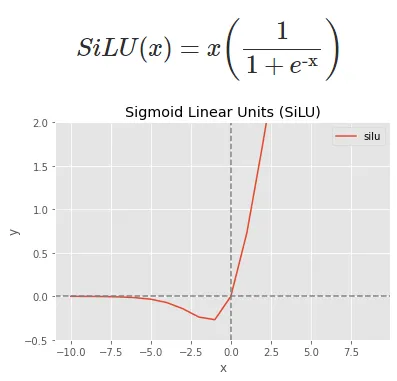
 - `fc_cancer`: Outputs a single logit per sample for binary classification.
  - `squeeze(1)`: Flattens the output to shape `[B]`, as required by binary loss functions like `BCEWithLogitsLoss`.

---

**Auxiliary Heads**
- `fc_aux`: A `ModuleList` of linear layers, one for each auxiliary target (e.g., view, implant, BIRADS, etc.).
- Each layer maps backbone features to a specific auxiliary class output.
- These secondary tasks help the model learn generalizable visual features, potentially improving performance on the main task through shared representation learning.

---

**Forward Pass**
- Processes the input image through the backbone to generate feature embeddings.
- Sends the shared features to:
  - The cancer head for the main prediction.
  - Each auxiliary head to predict auxiliary targets.
- Returns:
  - `cancer_out`: Tensor of shape `[B]` (one logit per image).
  - `aux_outs`: List of tensors, each of shape `[B, n_classes]` for its corresponding auxiliary task.


In [11]:
class BCModel(nn.Module):
    def __init__(self, model_name, aux_targets_dims):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        self.backbone_dim = self.backbone.num_features

        # Cancer head
        self.fc1 = nn.Linear(self.backbone_dim, 32)
        self.act = nn.SiLU()
        self.fc_cancer = nn.Linear(32, 1)

        # Aux heads
        self.fc_aux = nn.ModuleList([
            nn.Linear(self.backbone_dim, n_classes)
            for n_classes in aux_targets_dims
        ])

    def forward(self, x):
        x = self.backbone(x)

        # Cancer output head
        cancer_feat = self.fc1(x)
        cancer_feat = self.act(cancer_feat)
        cancer_out = self.fc_cancer(cancer_feat).squeeze(1)

        aux_outs = [head(x) for head in self.fc_aux]

        return cancer_out, aux_outs

### Focal Loss for Imbalanced Binary Classification

Defines a custom `FocalLoss` class to improve learning when dealing with imbalanced data, like cancer detection where positive cases are rare.

---

**Parameters**:
- **`alpha`**: Gives more importance to the positive class by weighting it higher. It can be computed using  
  **N_neg / (N_pos + N_neg)**
  so the model doesn't ignore cancer cases due to scarcity.
  
- **`gamma`**: Reduces the influence of easy or common examples, helping the model focus more on harder, uncertain predictions.

---

- Focal Loss begins with binary cross-entropy (BCE) to assess prediction error.
- It then emphasizes learning from harder or less confident predictions, while reducing focus on those the model already handles well.
- This helps the model improve where it struggles most, leading to better overall performance, especially in imbalanced data.

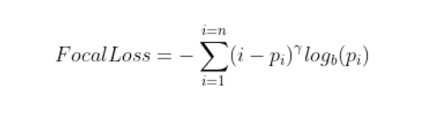

In [5]:
# LOSSES
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()

### Image Transformation Pipeline for Training and Validation

Defines a `build_transforms` function to apply preprocessing and augmentation to images:

---
  - Converts image arrays to PIL images (`T.ToPILImage()`).

- **Conditional Augmentations (for training)**:
  - Enabled only if `train=True` and `CFG.augment` is `True`.
  - Applies `ColorJitter` randomly based on `CFG.pixel_aug` probability.
  - Applies random horizontal and vertical flips depending on `CFG.hflip` and `CFG.vflip`.
  - Applies random rotation based on `CFG.rot`.

Using probability (e.g., 90% chance of applying `ColorJitter`) prevents over-augmenting the data. It ensures that not every image is distorted in the same way, helping the model generalize better by seeing a diverse set of variations without losing the original signal too often.

  - Converts images back to tensors (`T.ToTensor()`), suitable for PyTorch models.

- **Returns**:
  - A `torchvision.transforms.Compose` object containing the full augmentation pipeline.

In [13]:
# TRANSFORMS
def build_transforms(train=True):
    aug = [T.ToPILImage()]
    if train and CFG.augment:
        aug += [
            T.ColorJitter(CFG.bri, CFG.cont, CFG.sat, CFG.hue)
            if np.random.rand() < CFG.pixel_aug else T.Lambda(lambda x: x),
            T.RandomHorizontalFlip(p=0.5 if CFG.hflip else 0.0),
            T.RandomVerticalFlip(p=0.5 if CFG.vflip else 0.0),
            T.RandomRotation(degrees=CFG.rot)
        ]
    aug.append(T.ToTensor())
    return T.Compose(aug)

### Validation Loop with Auxiliary Loss and Mixed Precision

Evaluates the multi-task model on a validation set, combining cancer and auxiliary classification losses.

---

**Inputs**  
- `cancer_criterion`: Loss function for the main binary task (e.g. FocalLoss).  
- `aux_criterion`: CrossEntropyLoss for each auxiliary classification task.  
- `threshold`: Optional probability threshold for classification metrics.  

---

**Validation Steps**  
- Sets model to evaluation mode with `model.eval()` and disables gradient computation using `torch.no_grad()`.  
- Uses `autocast('cuda')` for mixed precision, reducing memory use and improving speed.  
- For each batch:
  - Moves images, cancer labels, and aux labels to the GPU.
  - Performs a forward pass to get `cancer_outputs` and `aux_outputs`.
  - Computes:
    - `cancer_loss`: Loss for main task.
    - `aux_loss`: Mean loss across all auxiliary tasks.
    - `total_loss`: Weighted average using `CFG.aux_loss_weight`.
  - Skips invalid batches (NaNs or Infs).
  - Applies `sigmoid` to cancer logits, collects predictions and targets.
  - Tracks running average loss using `tqdm`.

---

**Final Evaluation**  
- Concatenates predictions and labels.
- If `use_classification_metrics=True`:
  - Computes accuracy, precision, recall, and F1 at a fixed threshold.
- Otherwise:
  - Computes probabilistic F1, thresholded F1, AUC, and best threshold.

---

**Returns**  
- Validation loss and performance metrics for model evaluation.

In [3]:
def validate(model, loader, cancer_criterion, aux_criterion, device, threshold, use_classification_metrics=False):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="[Valid]", leave=False)

    with torch.no_grad():
        for batch_idx, (images, (cancer_targets, aux_targets)) in enumerate(pbar):
            images = images.to(device)
            cancer_targets = cancer_targets.to(device)
            aux_targets = aux_targets.to(device)

            with autocast('cuda'):
                cancer_outputs, aux_outputs = model(images)

            if torch.isnan(cancer_outputs).any() or torch.isinf(cancer_outputs).any():
                print(f"Skipping batch {batch_idx} due to invalid cancer_outputs.")
                continue

            cancer_loss = cancer_criterion(cancer_outputs, cancer_targets)

            aux_losses = [
                aux_criterion(aux_outputs[i], aux_targets[:, i])
                for i in range(len(aux_outputs))
            ]
            aux_loss = torch.stack(aux_losses).mean()
            
            aux_weight = CFG.aux_loss_weight
            cancer_weight = 1.0 - aux_weight
            
            total_loss = cancer_weight * cancer_loss + aux_weight * aux_loss

            running_loss += total_loss.item() * images.size(0)

            preds = torch.sigmoid(cancer_outputs)
            if torch.isnan(preds).any():
                print(f"NaN detected in preds at batch {batch_idx}")
                continue

            all_preds.append(preds.cpu())
            all_targets.append(cancer_targets.cpu())

            avg_loss = running_loss / ((pbar.n + 1) * loader.batch_size)
            pbar.set_postfix(batch_loss=cancer_loss.item(), avg_loss=f"{avg_loss:.4f}")

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    epoch_loss = running_loss / len(loader.dataset)

    if use_classification_metrics:
        metrics = compute_classification_metrics(all_preds, all_targets, threshold=threshold)
        print(f"[OOF Prediction] Metrics @ Thr={threshold:.4f} → "
              f"Acc: {metrics['acc']:.4f} | Prec: {metrics['prec']:.4f} | "
              f"Rec: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f}")
        return epoch_loss, metrics, threshold
    else:
        pf1, pf1_thr, auc, best_thr = compute_metrics(all_preds, all_targets)
        print(f"[Val] Metrics → val_pf1: {pf1:.4f} | val_pf1_thr: {pf1_thr:.4f} | val_auc: {auc:.4f} | val_Best_Thr: {best_thr:.4f}")
        return epoch_loss, pf1, pf1_thr, auc, best_thr

### Training Loop with Auxiliary Loss and Mixed Precision

Performs one training epoch for a multi-task model that predicts both cancer labels and auxiliary targets.

---

**Inputs**  
- `cancer_criterion`: Loss function for the main cancer task (e.g. FocalLoss).  
- `aux_criterion`: CrossEntropyLoss used for each auxiliary classification task.  
- `scaler`: GradScaler for mixed precision training.  
- `epoch`: Current training epoch, used for logging.  

---

**Training Steps**  
- Sets model to training mode with `model.train()`.  
- Wraps the loop with `autocast('cuda')` to enable automatic mixed precision, which reduces memory use and improves speed.  
- For each batch:
  - Moves input images and both target types (cancer and auxiliary) to the GPU.
  - Computes cancer logits and auxiliary logits from the model.
  - Calculates:
    - `cancer_loss`: from predicted logits and true cancer labels.
    - `aux_loss`: average of CrossEntropy losses for each auxiliary head.
    - `total_loss`: combined using weights from `CFG.aux_loss_weight` and `1 - aux_weight`.
  - Skips batch if `total_loss` contains NaN or Inf.
  - Scales the loss using AMP's `scaler`, then performs backward pass and optimizer step.

---

**Metric Collection**  
- Applies `sigmoid` to cancer outputs to obtain prediction probabilities.
- Collects predictions and targets for computing metrics.
- Logs batch loss and running average using `tqdm`.

---

**Returns**  
- Training loss and evaluation metrics (probabilistic F1, thresholded F1, AUC, and best threshold) for the epoch.

In [15]:
def train_one_epoch(model, loader, optimizer, cancer_criterion, aux_criterion, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    cancer_preds, cancer_targets = [], []

    pbar = tqdm(loader, desc=f"[Train] Epoch {epoch+1}", leave=False)

    for images, (cancer_labels, aux_labels) in pbar:
        images = images.to(device)
        cancer_labels = cancer_labels.to(device)
        aux_labels = aux_labels.to(device)

        optimizer.zero_grad()

        with autocast('cuda'):
            cancer_logits, aux_logits = model(images)

            cancer_loss = cancer_criterion(cancer_logits, cancer_labels)

            aux_losses = [
                aux_criterion(aux_logits[i], aux_labels[:, i])
                for i in range(len(aux_logits))
            ]
            aux_loss = torch.stack(aux_losses).mean()

            aux_weight = CFG.aux_loss_weight
            cancer_weight = 1.0 - aux_weight
            
            total_loss = cancer_weight * cancer_loss + aux_weight * aux_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Skipping batch due to invalid loss.")
            continue

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += total_loss.item() * images.size(0)

        cancer_preds.append(torch.sigmoid(cancer_logits.detach().cpu()))
        cancer_targets.append(cancer_labels.detach().cpu())

        avg_loss = running_loss / ((pbar.n + 1) * loader.batch_size)
        pbar.set_postfix(batch_loss=total_loss.item(), avg_loss=f"{avg_loss:.4f}")

    cancer_preds = torch.cat(cancer_preds).numpy()
    cancer_targets = torch.cat(cancer_targets).numpy()

    pf1, pf1_thr, auc, best_thr = compute_metrics(cancer_preds, cancer_targets)
    epoch_loss = running_loss / len(loader.dataset)

    print(f"[Train Epoch {epoch+1}] loss: {epoch_loss:.4f} | pf1: {pf1:.4f} | pf1_thr: {pf1_thr:.4f} | AUC: {auc:.4f} | Best Thr: {best_thr:.4f}")

    return epoch_loss, pf1, pf1_thr, auc, best_thr

### K-Fold Training Loop with Auxiliary Targets and OOF Evaluation

Performs training and evaluation using K-fold cross-validation with support for auxiliary targets.

---

**Setup & Initialization**:
- Initializes lists and tracking variables:
  - `fold_epoch_results`: Stores metrics for each epoch.
  - `oof_records`: Stores out-of-fold performance per fold.
  - `best_fold_model_path`: Tracks best-performing model across folds.
  - `fold_best_thresholds`: Saves best threshold per fold.

---

**Per-Fold Loop**:
- Splits `train_df` into training and validation sets for the current fold.
- Initializes dataset, dataloader, model, optimizer, loss functions, and AMP scaler.
- Trains the model for `CFG.epochs` using:
  - `train_one_epoch()` for training.
  - `validate()` for validation using both cancer and auxiliary losses.
- Saves the model if validation F1 (thresholded) improves.

---

**Metric Logging**:
- Saves training and validation metrics per epoch into `fold_epoch_results`.
- Tracks the best threshold for each fold.

---

**Out-of-Fold (OOF) Evaluation**:
- Loads the best model checkpoint for the fold.
- Runs validation with `use_classification_metrics=True` to compute final OOF metrics (acc, prec, rec, F1).
- Saves results to `oof_records`.

---

**Final Output**:
- Saves:
  - Per-epoch metrics to `cv_epoch_results.csv`.
  - OOF metrics to `cv_oof_results.csv`.
- Prints:
  - Path to the best model across all folds.
  - Best thresholds per fold.


In [16]:
fold_epoch_results = []
oof_records = []
best_fold_model_path = None
best_fold_val_f1 = -np.inf
fold_best_thresholds = {}

# MAIN TRAINING LOOP
for fold in CFG.selected_folds:
    print(f"\n### FOLD: {fold} | IMAGE_SIZE: {CFG.img_size} | MODEL_NAME: {CFG.model_name} | BATCH_SIZE: {CFG.batch_size}")

    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_df = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_dataset = BreastCancerDataset(train_fold_df, transform=build_transforms(True))
    valid_dataset = BreastCancerDataset(valid_df, transform=build_transforms(False))

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)

    model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
    cancer_criterion = FocalLoss() if CFG.loss == 'focal' else nn.BCEWithLogitsLoss()
    aux_criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_val_f1 = -np.inf
    best_thr_this_fold = None

    print("Training...")
    for epoch in range(CFG.epochs):
        train_loss, train_pf1, train_pf1_thr, train_auc, train_best_thr = train_one_epoch(
            model, train_loader, optimizer, cancer_criterion, aux_criterion, device, scaler, epoch
        )

        val_loss, val_pf1, val_pf1_thr, val_auc, val_best_thr = validate(
            model, valid_loader, cancer_criterion, aux_criterion, device, threshold=None, use_classification_metrics=False
        )

        lr = optimizer.param_groups[0]['lr']

        # Save model if improved
        if val_pf1_thr > best_val_f1:
            best_val_f1 = val_pf1_thr
            best_thr_this_fold = val_best_thr
            model_path = f"model_fold{fold}.pth"
            torch.save(model.state_dict(), model_path)
            if val_pf1_thr > best_fold_val_f1:
                best_fold_val_f1 = val_pf1_thr
                best_fold_model_path = model_path
            print(f"Epoch {epoch+1}: val_pf1_thr improved, saving model to {model_path}")
        
        # Save metrics
        fold_epoch_results.append({
            "fold": fold,
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_pf1": train_pf1,
            "train_pf1_thr": train_pf1_thr,
            "train_auc": train_auc,
            "train_best_thr": train_best_thr,
            "val_loss": val_loss,
            "val_pf1": val_pf1,
            "val_pf1_thr": val_pf1_thr,
            "val_auc": val_auc,
            "val_best_thr": val_best_thr,
        })

    fold_best_thresholds[fold] = best_thr_this_fold
    print(f"Finished Fold {fold} | Best val_pf1_thr: {best_val_f1:.5f} | Best threshold: {best_thr_this_fold:.4f}")

    # OOF PREDICTION
    print("Evaluating best model for OOF...")
    best_model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
    best_model.load_state_dict(torch.load(f"model_fold{fold}.pth"))

    oof_loss, oof_metrics, _ = validate(
        best_model, valid_loader, cancer_criterion, aux_criterion, device,
        threshold=best_thr_this_fold, use_classification_metrics=True
    )

    # Save OOF metrics
    oof_records.append({
        "fold": fold,
        "oof_loss": oof_loss,
        "oof_f1": oof_metrics["f1"],
        "oof_acc": oof_metrics["acc"],
        "oof_prec": oof_metrics["prec"],
        "oof_rec": oof_metrics["rec"],
        "oof_best_thr": best_thr_this_fold
    })


    # CLEAN UP
    del model, optimizer, train_loader, valid_loader, scaler, cancer_criterion, aux_criterion, best_model
    torch.cuda.empty_cache()

# SAVE EPOCH-LEVEL RESULTS TO CSV
epoch_df = pd.DataFrame(fold_epoch_results)
epoch_df.to_csv("cv_epoch_results.csv", index=False)
print("Epoch-wise fold results saved to cv_epoch_results.csv")

# SAVE OOF RESULTS
pd.DataFrame(oof_records).to_csv("cv_oof_results.csv", index=False)
print("OOF fold results saved to cv_oof_results.csv")

# ANNOUNCE BEST MODEL ACROSS ALL FOLDS
print(f"Best model path across all folds: {best_fold_model_path}")
print(f"Best thresholds per fold: {fold_best_thresholds}")


### FOLD: 0 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.2941 | pf1: 0.3013 | pf1_thr: 0.2976 | AUC: 0.5623 | Best Thr: 0.3265


[Val] Metrics → val_pf1: 0.2834 | val_pf1_thr: 0.2868 | val_auc: 0.4805 | val_Best_Thr: 0.0000
Epoch 1: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 2] loss: 0.2301 | pf1: 0.3014 | pf1_thr: 0.3176 | AUC: 0.6212 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2981 | val_pf1_thr: 0.2966 | val_auc: 0.5730 | val_Best_Thr: 0.3469
Epoch 2: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 3] loss: 0.2097 | pf1: 0.3160 | pf1_thr: 0.3940 | AUC: 0.7091 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.3076 | val_pf1_thr: 0.3625 | val_auc: 0.6645 | val_Best_Thr: 0.3673
Epoch 3: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 4] loss: 0.1890 | pf1: 0.3539 | pf1_thr: 0.5006 | AUC: 0.7965 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3327 | val_pf1_thr: 0.3874 | val_auc: 0.6648 | val_Best_Thr: 0.4286
Epoch 4: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 5] loss: 0.1716 | pf1: 0.3969 | pf1_thr: 0.5751 | AUC: 0.8634 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3213 | val_pf1_thr: 0.3705 | val_auc: 0.6481 | val_Best_Thr: 0.3878


[Train Epoch 6] loss: 0.1536 | pf1: 0.4517 | pf1_thr: 0.6709 | AUC: 0.9075 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3139 | val_pf1_thr: 0.3052 | val_auc: 0.5901 | val_Best_Thr: 0.2041


[Train Epoch 7] loss: 0.1358 | pf1: 0.5197 | pf1_thr: 0.7658 | AUC: 0.9497 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.2935 | val_pf1_thr: 0.3142 | val_auc: 0.6026 | val_Best_Thr: 0.1837


[Train Epoch 8] loss: 0.1210 | pf1: 0.5879 | pf1_thr: 0.8112 | AUC: 0.9656 | Best Thr: 0.5102


[Val] Metrics → val_pf1: 0.2875 | val_pf1_thr: 0.3105 | val_auc: 0.5960 | val_Best_Thr: 0.3061
Finished Fold 0 | Best val_pf1_thr: 0.38737 | Best threshold: 0.4286
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.4286 → Acc: 0.7909 | Prec: 0.3802 | Rec: 0.3948 | F1: 0.3874

### FOLD: 1 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.2895 | pf1: 0.2997 | pf1_thr: 0.3001 | AUC: 0.5525 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2826 | val_pf1_thr: 0.2927 | val_auc: 0.5276 | val_Best_Thr: 0.2041
Epoch 1: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 2] loss: 0.2278 | pf1: 0.3062 | pf1_thr: 0.3445 | AUC: 0.6515 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.3120 | val_pf1_thr: 0.2966 | val_auc: 0.5679 | val_Best_Thr: 0.2245
Epoch 2: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 3] loss: 0.2029 | pf1: 0.3313 | pf1_thr: 0.4339 | AUC: 0.7554 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3159 | val_pf1_thr: 0.3254 | val_auc: 0.6241 | val_Best_Thr: 0.2857
Epoch 3: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 4] loss: 0.1808 | pf1: 0.3731 | pf1_thr: 0.5422 | AUC: 0.8372 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.3158 | val_pf1_thr: 0.3404 | val_auc: 0.6656 | val_Best_Thr: 0.3265
Epoch 4: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 5] loss: 0.1616 | pf1: 0.4345 | pf1_thr: 0.6570 | AUC: 0.9020 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.2984 | val_pf1_thr: 0.3215 | val_auc: 0.6138 | val_Best_Thr: 0.3469


[Train Epoch 6] loss: 0.1442 | pf1: 0.5063 | pf1_thr: 0.7407 | AUC: 0.9427 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.2939 | val_pf1_thr: 0.3279 | val_auc: 0.6159 | val_Best_Thr: 0.2857


[Train Epoch 7] loss: 0.1298 | pf1: 0.5655 | pf1_thr: 0.8167 | AUC: 0.9640 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3117 | val_pf1_thr: 0.3636 | val_auc: 0.6709 | val_Best_Thr: 0.3673
Epoch 7: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 8] loss: 0.1097 | pf1: 0.6355 | pf1_thr: 0.8643 | AUC: 0.9825 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.2370 | val_pf1_thr: 0.3289 | val_auc: 0.6172 | val_Best_Thr: 0.1429
Finished Fold 1 | Best val_pf1_thr: 0.36364 | Best threshold: 0.3673
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.3673 → Acc: 0.7634 | Prec: 0.3310 | Rec: 0.4034 | F1: 0.3636

### FOLD: 2 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.2863 | pf1: 0.2934 | pf1_thr: 0.2888 | AUC: 0.5498 | Best Thr: 0.3265


[Val] Metrics → val_pf1: 0.3036 | val_pf1_thr: 0.3105 | val_auc: 0.5250 | val_Best_Thr: 0.2857
Epoch 1: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 3] loss: 0.2050 | pf1: 0.3171 | pf1_thr: 0.3984 | AUC: 0.7226 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3156 | val_pf1_thr: 0.3727 | val_auc: 0.6528 | val_Best_Thr: 0.3673
Epoch 3: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 4] loss: 0.1872 | pf1: 0.3506 | pf1_thr: 0.4762 | AUC: 0.8014 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3075 | val_pf1_thr: 0.3591 | val_auc: 0.6407 | val_Best_Thr: 0.2857


[Train Epoch 5] loss: 0.1710 | pf1: 0.3886 | pf1_thr: 0.5649 | AUC: 0.8553 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.3571 | val_pf1_thr: 0.3956 | val_auc: 0.6852 | val_Best_Thr: 0.3673
Epoch 5: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 6] loss: 0.1511 | pf1: 0.4591 | pf1_thr: 0.6732 | AUC: 0.9174 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3583 | val_pf1_thr: 0.3931 | val_auc: 0.6815 | val_Best_Thr: 0.3878


[Train Epoch 7] loss: 0.1368 | pf1: 0.5244 | pf1_thr: 0.7575 | AUC: 0.9536 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.3252 | val_pf1_thr: 0.3765 | val_auc: 0.6671 | val_Best_Thr: 0.3061


[Train Epoch 8] loss: 0.1193 | pf1: 0.5926 | pf1_thr: 0.8244 | AUC: 0.9740 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.3191 | val_pf1_thr: 0.3745 | val_auc: 0.6567 | val_Best_Thr: 0.1633
Finished Fold 2 | Best val_pf1_thr: 0.39563 | Best threshold: 0.3673
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.3673 → Acc: 0.6649 | Prec: 0.2923 | Rec: 0.6118 | F1: 0.3956

### FOLD: 3 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.2981 | pf1: 0.3011 | pf1_thr: 0.2951 | AUC: 0.5368 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2933 | val_pf1_thr: 0.2872 | val_auc: 0.5735 | val_Best_Thr: 0.3469
Epoch 1: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 2] loss: 0.2349 | pf1: 0.3092 | pf1_thr: 0.3412 | AUC: 0.6489 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2770 | val_pf1_thr: 0.2815 | val_auc: 0.5809 | val_Best_Thr: 0.2041


[Train Epoch 3] loss: 0.2131 | pf1: 0.3300 | pf1_thr: 0.4227 | AUC: 0.7321 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.2831 | val_pf1_thr: 0.3009 | val_auc: 0.6005 | val_Best_Thr: 0.3469
Epoch 3: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 4] loss: 0.1938 | pf1: 0.3586 | pf1_thr: 0.5019 | AUC: 0.8031 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.3339 | val_pf1_thr: 0.3876 | val_auc: 0.7113 | val_Best_Thr: 0.4286
Epoch 4: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 5] loss: 0.1746 | pf1: 0.4136 | pf1_thr: 0.6149 | AUC: 0.8711 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3174 | val_pf1_thr: 0.3542 | val_auc: 0.6759 | val_Best_Thr: 0.4490


[Train Epoch 6] loss: 0.1511 | pf1: 0.4782 | pf1_thr: 0.7145 | AUC: 0.9274 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3245 | val_pf1_thr: 0.3719 | val_auc: 0.6776 | val_Best_Thr: 0.3878


[Train Epoch 7] loss: 0.1384 | pf1: 0.5347 | pf1_thr: 0.7592 | AUC: 0.9504 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3348 | val_pf1_thr: 0.3383 | val_auc: 0.6614 | val_Best_Thr: 0.3878


[Train Epoch 8] loss: 0.1224 | pf1: 0.5989 | pf1_thr: 0.8442 | AUC: 0.9737 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.2945 | val_pf1_thr: 0.3167 | val_auc: 0.6326 | val_Best_Thr: 0.2653
Finished Fold 3 | Best val_pf1_thr: 0.38763 | Best threshold: 0.4286
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.4286 → Acc: 0.7917 | Prec: 0.3521 | Rec: 0.4312 | F1: 0.3876
Epoch-wise fold results saved to cv_epoch_results.csv
OOF fold results saved to cv_oof_results.csv
Best model path across all folds: model_fold2.pth
Best thresholds per fold: {0: np.float64(0.42857142857142855), 1: np.float64(0.36734693877551017), 2: np.float64(0.36734693877551017), 3: np.float64(0.42857142857142855)}


### Plot Training and Validation Metrics by Fold

Visualizes the training and validation metrics across all folds for every epoch using line plots:

---

**Input & Setup**:
- Loads per-epoch training results from `cv_epoch_results.csv` into `results_df`.
- Defines key metrics to plot (e.g., loss, probabilistic F1, thresholded F1, AUC).

---

**Subplot Layout**:
- Calculates the number of subplot rows and columns based on the number of metrics.
- Creates a subplot grid (`axs`) using `matplotlib`.

---

**Plotting Loop**:
- For each metric:
  - Skips and disables plots for missing metrics (with a warning).
  - Plots the metric over epochs for each fold using line charts.
  - Adds title, axis labels, grid, and legend.

---

**Post-processing**:
- Hides unused subplots (in case grid is larger than the number of metrics).
- Applies tight layout and adds a supertitle.
- Saves the full plot as `metrics_per_fold.png`.
- Displays the figure.

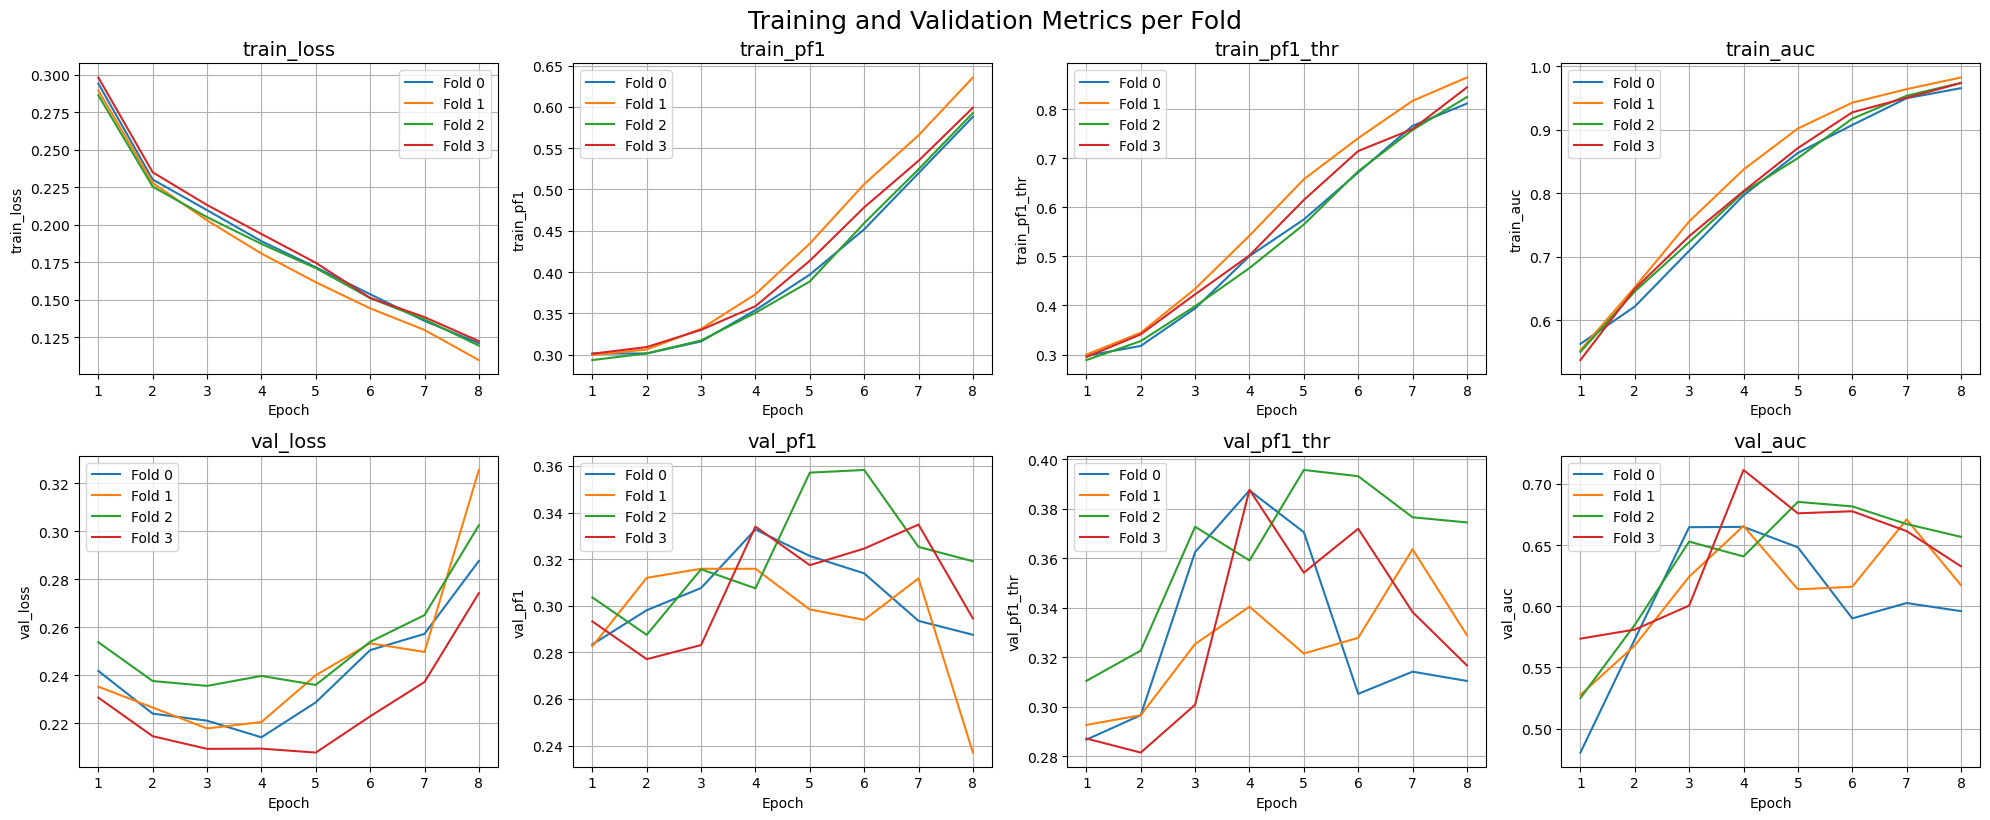

In [17]:
results_df = pd.read_csv("cv_epoch_results.csv")

metrics = [
    'train_loss', 'train_pf1', 'train_pf1_thr', 'train_auc',
    'val_loss', 'val_pf1', 'val_pf1_thr', 'val_auc']

# Set number of rows and columns for subplots
n_cols = 4
n_rows = (len(metrics) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    if metric not in results_df.columns:
        print(f"Warning: '{metric}' not found in DataFrame columns. Skipping.")
        ax.axis('off')
        continue
    for fold in sorted(results_df['fold'].unique()):
        fold_data = results_df[results_df['fold'] == fold]
        ax.plot(fold_data['epoch'], fold_data[metric], label=f"Fold {fold}")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

# Hide unused axes
for i in range(len(metrics), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("Training and Validation Metrics per Fold", fontsize=18, y=1.02)
plt.savefig("metrics_per_fold.png")
plt.show()

### Grad-CAM Utility Functions

Provides tools to generate and visualize Grad-CAM heatmaps for the main cancer classification output:

---

**Function: `generate_gradcam_heatmap(model, image_tensor, target_layer)`**  
- Registers forward and backward hooks to capture:
  - **Activations** from the selected `target_layer`.
  - **Gradients** during the backward pass.
- Performs a forward pass to obtain the **cancer output**.
- Applies `sigmoid` and triggers `backward()` on the scalar prediction.
- Removes hooks and computes the Grad-CAM heatmap:
  - Averages gradients spatially to get importance weights.
  - Combines weights with feature activations.
  - Applies ReLU and normalizes the result.

**Returns**:
- The normalized heatmap.
- The predicted probability score for the cancer output.

---

**Function: `overlay_gradcam_on_image(original_img, heatmap, alpha=0.4)`**  
- Resizes the Grad-CAM heatmap to the original image size.
- Applies a JET color map to the heatmap.
- Overlays it with the original image using a transparency factor `alpha`.
- Converts the image back to RGB format.

**Returns**:
- An RGB image with the Grad-CAM heatmap visually overlaid for interpretation.

In [18]:
# --- GradCAM Utilities ---
def generate_gradcam_heatmap(model, image_tensor, target_layer):
    activations = []
    gradients = []

    def save_features_hook(module, input, output):
        activations.append(output.detach())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    forward_hook = target_layer.register_forward_hook(save_features_hook)
    backward_hook = target_layer.register_full_backward_hook(save_gradients_hook)

    model.zero_grad()
    cancer_output, _ = model(image_tensor.unsqueeze(0))
    pred_score = torch.sigmoid(cancer_output)
    pred_score.backward()

    forward_hook.remove()
    backward_hook.remove()

    gradients_data = gradients[0].squeeze(0).cpu().numpy()
    activations_data = activations[0].squeeze(0).cpu().numpy()

    weights = np.mean(gradients_data, axis=(1, 2))
    cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations_data, axis=0)

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-7)
    return cam, pred_score.item()

def overlay_gradcam_on_image(original_img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    overlay_bgr = cv2.addWeighted(colored_heatmap, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    return overlay_rgb



### Evaluate Best Model on Test Set and Visualize Predictions with Grad-CAM

This block performs final model evaluation on the held-out test set and visualizes selected predictions using Grad-CAM:

---

#### **Test Inference:**
- **Dataset & Loader**: Creates a test dataset and DataLoader with no augmentation.
- **Load Best Model**: Loads the best model checkpoint saved during cross-validation.
- **Inference Loop**:
  - Uses `torch.no_grad()` and `autocast` for efficient inference.
  - Applies sigmoid to logits to get predicted probabilities.
  - Collects predictions and ground truths in `test_df`.

#### **Metric Evaluation:**
- Calculates:
  - Probabilistic F1 (`pF1`)
  - Best thresholded F1
  - AUC
- Prints the final evaluation metrics and saves `test_predictions.csv`.

---

#### **Grad-CAM Visualization:**
- **Sample Selection**:
  - Selects three samples with the **lowest**, **middle**, and **highest** prediction scores from the test set.

- **Grad-CAM Generation**:
  - Loads and preprocesses each image.
  - Selects `model.backbone.blocks[-2]` as the Grad-CAM target layer.
  - Generates and overlays the Grad-CAM heatmap.

- **Display**:
  - Plots and saves the Grad-CAM overlays for the three samples in a single figure: `test_sample_predictions_with_gradcam.png`.


Testing on test split: 100%|██████████| 87/87 [00:20<00:00,  4.20it/s]



--- TEST RESULTS ---
AUC:        0.7256
pF1 (prob): 0.3624
pF1 (thr):  0.4070
Test predictions saved to test_predictions.csv
Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png


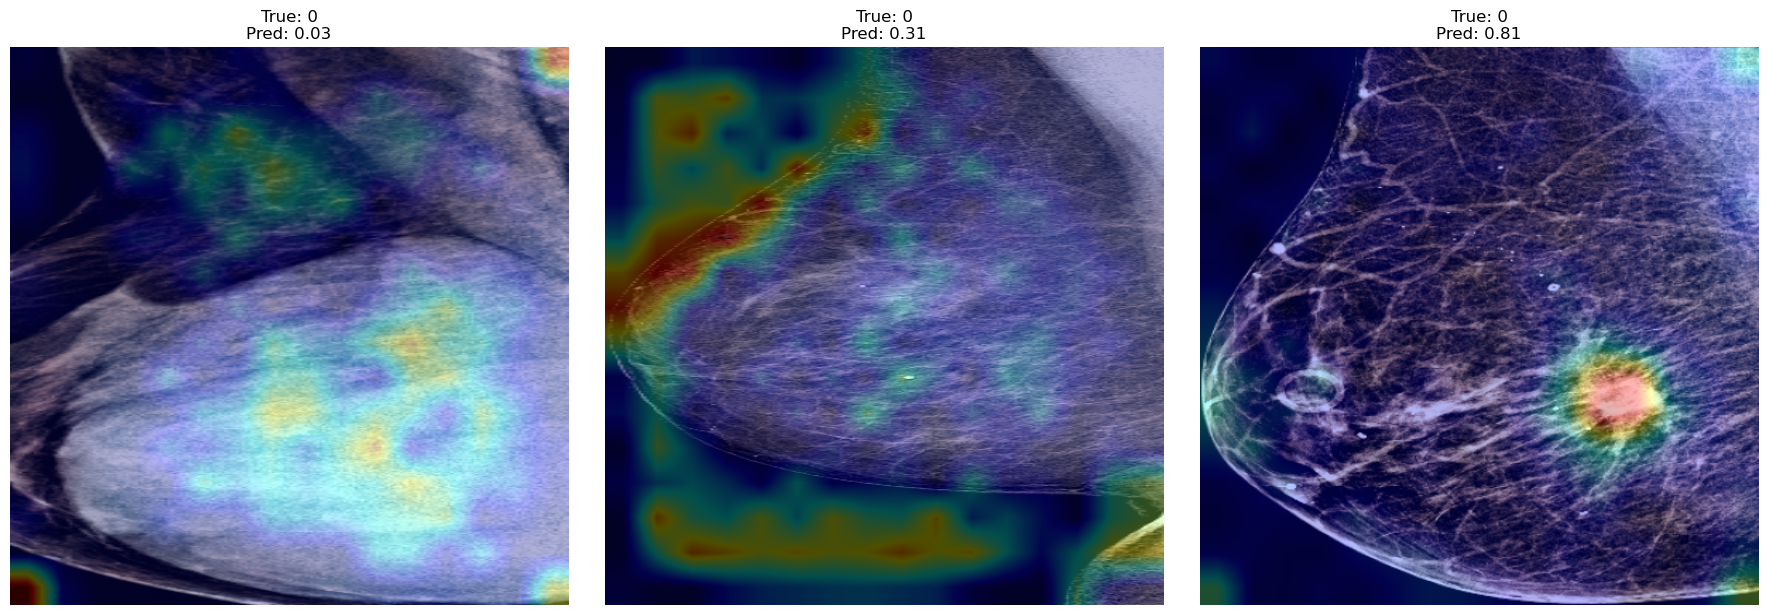

In [19]:
# --- Build test dataset and loader ---
test_dataset = BreastCancerDataset(test_df, transform=build_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)

# --- Load best model ---
model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
model.load_state_dict(torch.load(best_fold_model_path))
model.eval()

# --- Store test predictions ---
all_preds = []
all_targets = []

with torch.no_grad():
    for images, (cancer_targets, aux_targets) in tqdm(test_loader, desc="Testing on test split"):
        images = images.to(device)
        cancer_targets = cancer_targets.to(device)
    
        with autocast(device_type='cuda'):
            cancer_outputs, _ = model(images)
    
        preds = torch.sigmoid(cancer_outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(cancer_targets.cpu().numpy())

# --- Save predictions to test_df ---
test_df['pred'] = all_preds
test_df['target'] = all_targets


# --- Compute metrics ---
pf1, best_thr_f1, auc, _ = compute_metrics(test_df['pred'].values, test_df['target'].values)

print(f"\n--- TEST RESULTS ---")
print(f"AUC:        {auc:.4f}")
print(f"pF1 (prob): {pf1:.4f}")
print(f"pF1 (thr):  {best_thr_f1:.4f}")

test_df.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to test_predictions.csv")

# --- Visualization of 3 samples with GradCAM ---
# Sort by prediction probability
sorted_df = test_df.sort_values(by="pred").reset_index(drop=True)

# Get lowest, middle, and highest predictions
lowest  = sorted_df.iloc[0]
middle  = sorted_df.iloc[len(sorted_df) // 2]
highest = sorted_df.iloc[-1]

# Combine into DataFrame
sampled = pd.DataFrame([lowest, middle, highest])
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(sampled.itertuples()):
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, CFG.img_size[::-1])

    img_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).permute(2, 0, 1).to(device)

    target_layer = model.backbone.blocks[-2]
    heatmap, _ = generate_gradcam_heatmap(model, img_tensor, target_layer)

    overlay = overlay_gradcam_on_image(img_resized, heatmap, alpha=0.3)

    axs[i].imshow(overlay)
    axs[i].axis('off')
    axs[i].set_title(f"True: {int(row.target)}\nPred: {row.pred:.2f}", fontsize=12)

plt.tight_layout()
plt.savefig("test_sample_predictions_with_gradcam.png")
print("Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png")